In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [6]:
n_samples = 100
X = np.random.randn(n_samples, 1)
y = 3 * X.squeeze() + 2 + np.random.randn(n_samples)

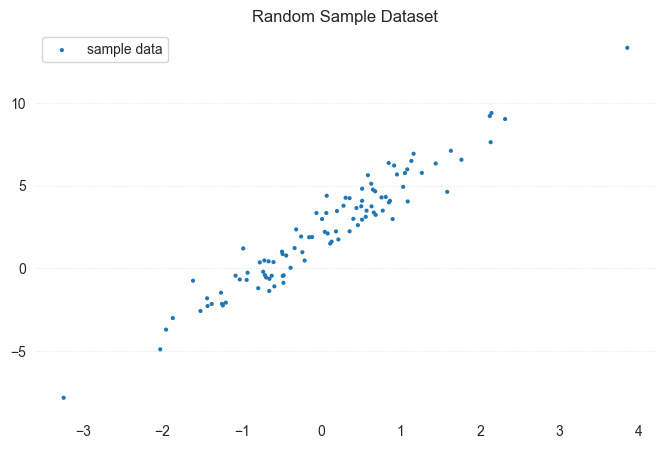

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(X, y, label = 'sample data', lw = 0.5, marker = '.', edgecolor = 'None')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Random Sample Dataset')
plt.show()

Tensor transformation

In [8]:
X_train_tensor = torch.tensor(X, dtype = torch.float32)
y_train_tensor = torch.tensor(y, dtype = torch.float32).unsqueeze(1)

Class declaration

In [9]:
class LinearRegressionNetwork(nn.Module) :
    def __init__(self, input_dim : int) -> None :
        super(LinearRegressionNetwork, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x : torch.Tensor) -> torch.Tensor :
        return self.linear(x)

In [10]:
X.shape

(100, 1)

In [29]:
model = LinearRegressionNetwork(input_dim = X.shape[1]) # size = 1
criterion = nn.MSELoss() # for regression, we use MSE Optimization
optimizer = optim.SGD(model.parameters(), lr = 0.1) # Stochastic Gradient Descent

In [30]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train() # set train mode
    optimizer.zero_grad() # optimizer initialize
    
    # predict and calculate loss function
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor) # calculate MSE Loss
    
    # backpropagation
    loss.backward()
    optimizer.step()

In [31]:
model.eval() # set evaluation mode
with torch.no_grad() :
    predicted = model(X_train_tensor).numpy()

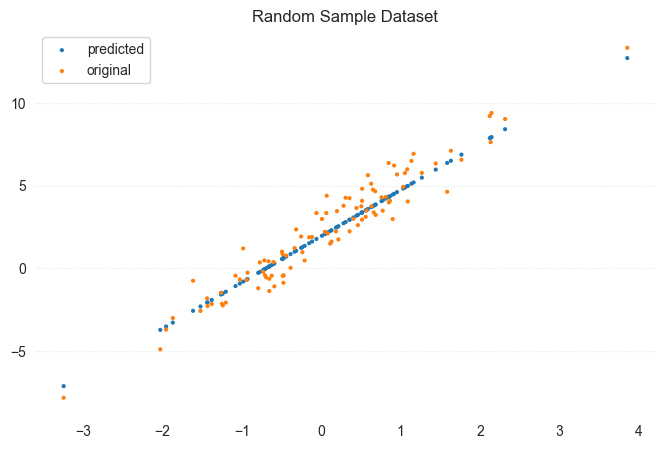

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(X_train_tensor, predicted, label = 'predicted', lw = 0.5, marker = '.', edgecolor = 'None')
plt.scatter(X, y, label = 'original', lw = 0.5, marker = '.', edgecolor = 'None')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Random Sample Dataset')
plt.show()

Explainability

In [35]:
print('weights')
print(model.linear.weight)

weights
Parameter containing:
tensor([[2.7992]], requires_grad=True)


In [36]:
print('bias')
print(model.linear.bias)

bias
Parameter containing:
tensor([1.9469], requires_grad=True)


In [37]:
weights = model.linear.weight.detach().numpy().flatten()
bias = model.linear.bias.detach().numpy().flatten()

In [43]:
residuals = y - predicted.squeeze()

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate R-squared Error
mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted)

In [72]:
from statsmodels.iolib.summary2 import Summary
from scipy.stats import jarque_bera, skew, kurtosis
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

In [89]:
from scipy import stats

def summary(model, X, y, residuals) :
    smry = Summary()
    
    X = sm.add_constant(X)
    
    n = len(y) 
    p = X.shape[1]
    
    mse = np.sum(residuals ** 2) / (n - p)
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * mse) + 1)
    
    k = X_train_tensor.shape[1] + 1 
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + k * np.log(n)
    hqic = -2 * log_likelihood + 2 * k * np.log(np.log(n))
    
    # Model Information
    model_info = [
        ('Dep. Variable:', 'predicted'),
        ('Model:', 'LinearNet'),
        ('Date:', pd.Timestamp.now().strftime('%a, %d %b %Y')),
        ('Time:', pd.Timestamp.now().strftime('%H:%M:%S')),
        ('Sample:', f'{len(X)}'),
        ('No. Observations:', f"{len(X)}"),

        ('Log Likelihood', f"{log_likelihood:.3f}"),
        ('AIC', f"{aic:.3f}"),
        ('BIC', f"{bic:.3f}"),
        ('HQIC', f"{hqic:.3f}"),
    ]
    
    smry.add_dict(
        dict(model_info, n_cols = 2)
    )
    
    weights = model.linear.weight.detach().numpy().flatten()
    bias = model.linear.bias.detach().numpy().flatten()
    
    XTX_inv = np.linalg.inv(np.dot(X.T, X))  # (X'X)^-1
    param_variances = mse * np.diag(XTX_inv)  # 각 파라미터의 분산
    std_err = np.sqrt(param_variances)  # 표준 오차
    
    t_values = weights / std_err
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df=n-p))
    
    conf_int = np.column_stack([
        weights - 1.96 * std_err, 
        weights + 1.96 * std_err  
    ])
        
    params_data = pd.DataFrame({
        "coef": np.append(bias, weights),
        "std err": std_err, 
        "t": t_values,
        "P>|t|": p_values,  
        "[0.025": conf_int[:,0],
        "0.975]": conf_int[:,1]
    }, index = ['const', 'X1'])
    
    smry.add_df(params_data)
    
    # evaluation
    mse = mean_squared_error(y, predicted)
    r2 = r2_score(y, predicted)
    
    additional_info = [
        ('MSE:', f"{mse:.4f}"),
        ('R-squared:', f"{r2:.4f}")
    ]
    
    # residual_test
    jb_test = jarque_bera(residuals)
    dw_test = durbin_watson(residuals)
    bp_test = het_breuschpagan(residuals, X)
    lb_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
    
    residual_tests = [
        ('Jarque-Bera Test:', f"{jb_test.statistic:.2f}"), 
        ('Prob(JB):', f"{jb_test.pvalue:.2f}"), 
        ('Skew:', f"{skew(residuals):.2f}"), 
        ('Kurtosis:', f"{kurtosis(residuals):.2f}"), 
        ('Durbin-Watson:', f"{dw_test:.2f}"),
        ('Breusch-Pagan Test:', f"{bp_test[0]:.2f}"),
        ('Prob(H):', f"{bp_test[1]:.2f}")
    ]
    
    smry.add_dict(dict(residual_tests))
    smry.title = 'LinearNet Regression Results'
    
    return smry

In [87]:
smry = summary(model, X, y, residuals)

In [88]:
print(smry)

               LinearNet Regression Results
Dep. Variable:    predicted        Log Likelihood -134.812
Model:            LinearNet        AIC            273.625 
Date:             Tue, 24 Sep 2024 BIC            278.835 
Time:             01:20:37         HQIC           275.734 
Sample:           100              n_cols         2.0000  
No. Observations: 100                                     
-----------------------------------------------------------
            coef   std err     t     P>|t|   [0.025  0.975]
-----------------------------------------------------------
Intercept  1.9469   0.0933  29.9919  0.0000  2.6163  2.9821
X1         2.7992   0.0864  32.4152  0.0000  2.6299  2.9685
----------------------------------------------------------
Jarque-Bera Test:     2.25     Durbin-Watson:         1.80
Prob(JB):             0.33     Breusch-Pagan Test:    1.54
Skew:                 0.24     Prob(H):               0.21
Kurtosis:             -0.56                               

